In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)
df.head()
save = False

In [3]:
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]
y = nb_utils.get_target(df_info,df)

In [4]:
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train = X_train[:79,:]
y_train = y_train[:79]
X_train.shape, y_train.shape

((79, 13), (79,))

In [7]:
# calculate sklearn default values for C and gamma
n_features = X_train.shape[1]
gamma = 1/(n_features*X_train.var())
C = 1.0
print("Gamma = " + str(gamma))
print("C = " + str(C))

Gamma = 1.070349905089307
C = 1.0


In [43]:

#try to optimize regressor hps
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
best, C_best, epsilon_best, gamma_best = -100, None, None, None
for _ in range(1000):
	C = np.exp(np.random.uniform(np.log(1e-3),np.log(10.0)))
	gamma = np.exp(np.random.uniform(np.log(1e-3),np.log(10.0)))
	epsilon = np.exp(np.random.uniform(np.log(1e-3),np.log(1)))
	model = SVR(C=C,epsilon=epsilon,gamma=gamma)
	cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=_)
	cvs = cvs.mean()
	if best < cvs:
		best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
print(f'Best cross validation average r^2 achieved on classical SVR is {best}')
print(f'-> Achieved using C={C_best}, epsilon={epsilon_best}, gamma={gamma_best}')

Best cross validation average r^2 achieved on classical SVR is 0.8875172083187295
-> Achieved using C=8.836178204816694, epsilon=0.02071095136869859, gamma=0.1865953227493358


In [ ]:
qsvr_model = QSVR.QSVR()

In [73]:
random_seed = 10 
# not working if I try to set gamma and C manually
# if the training set (n_samples) is not small enough it will fail to find and embedding. n_samples 28 is worse than 20 
# if K is incremented it also fails
#qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.1, k0 = 0.05, n_samples = 21, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=20, C = C, gamma = gamma) #insert stuff
'''
# best r2 up to now
qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=40)
'''
qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=40, gamma=0.1, C=67.61)

best value for gamma is 0.1, best value for C is 67.61
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers


In [74]:
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
mse = []
for i in range(y_pred.shape[0]):
    mse.append(mean_squared_error(y_pred[i],y_test))
mse

[0.008022189375617926,
 0.018816895823659,
 0.008029861635205682,
 0.0066310229880489025,
 0.022737687317029947,
 0.005705598064555769]

In [75]:
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
r2 = []
for i in range(y_pred.shape[0]):
    r2.append(r2_score(y_pred[i],y_test))
r2

[0.9058861759298176,
 0.8841562796716143,
 0.9052083995296909,
 0.9280280728437256,
 0.8698535276071606,
 0.9362658563889188]

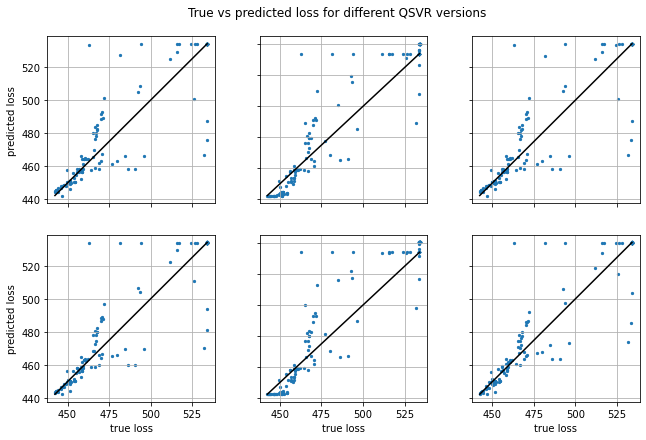

In [76]:
fig, axs = plt.subplots(2,3,figsize=(9, 6))
fig.suptitle("True vs predicted loss for different QSVR versions")
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='true loss', ylabel='predicted loss')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

x = y_scaler.inverse_transform(y_test.reshape(-1, 1))

for i in range(y_pred.shape[0]):
    y = y_scaler.inverse_transform(y_pred[i,:].reshape(-1, 1))
    axs.flat[i].scatter(x,y,s=5)
    axs.flat[i].plot([x.min(),x.max()],[x.min(),x.max()],'k')

plt.show()

In [79]:
# SAVE the needed attributes to reuse the model to do predictions
def save_qsvr(qsvr_model, name):
	qsvr_attrs = {
		'X_train_reshaped' : qsvr_model.X_train_reshaped,
		'Y_train': qsvr_model.Y_train,
		'all_alphas' : qsvr_model.all_alphas,
		'B' : qsvr_model.B,
		'K' : qsvr_model.K,
		'epsilon' : qsvr_model.epsilon,
		'best_gamma' : qsvr_model.best_gamma,
		'best_C' :qsvr_model.best_C,
		'change_to_logarithmic' :qsvr_model.change_to_logarithmic,
	}
	dump(qsvr_attrs,name+".joblib")

In [80]:
if save == True:
	date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")	
	save_qsvr(qsvr_model, "qsvr_attrs"+date)
	dump(x_scaler,"x_scaler_q"+date+".joblib") 
	dump(y_scaler,"y_scaler_q"+date+".joblib")

In [86]:
sufix = '_2022_08_18-02:08:37.344989_PM' # write the date extension of the model you want to load
#ld_x_scaler = load("x_scaler_q"+sufix+".joblib") 
#ld_y_scaler = load("y_scaler_q"+sufix+".joblib")
ld_qsvr_attrs = load( "qsvr_attrs"+sufix+".joblib")
print(f'B = {ld_qsvr_attrs["B"]}')
print(f'K = {ld_qsvr_attrs["K"]}')
print(f'epsilon = {ld_qsvr_attrs["epsilon"]}')
print(f'best_gamma = {ld_qsvr_attrs["best_gamma"]}')
print(f'best_C = {ld_qsvr_attrs["best_C"]}')

B = 2
K = 3
epsilon = 0.02
best_gamma = 0.1
best_C = 67.61


In [26]:
# instantiate a QSVR that can be used to do predictions
pred_model = QSVR.QSVR() 
# set the QSVR attributes needed for predictions
for attr in ld_qsvr_attrs.keys():
    setattr(pred_model, attr, ld_qsvr_attrs[attr])

# use the QSVR to do a prediction
# loaded scalers may be needed
y_pred = pred_model.predict(X_test)

# make use of the prediction
r2 = []
for i in range(y_pred.shape[0]):
    r2.append(r2_score(y_pred[i],y_test))
r2

[0.902828053334424,
 0.9123044591285047,
 0.9029195202470672,
 0.9124470278391059,
 0.9123044591285047,
 0.8487914544304758]

In [51]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

rs = 0
num_runs = 0
r2 = np.zeros((num_runs, 6))
for i in range(num_runs):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train = X_train[:79,:]
	y_train = y_train[:79]
	
	# QSVR code
	qsvr_model = QSVR.QSVR() # instantiate
	#RUN ON D-WAVE
	qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=rs+i, n_samples_for_gamma_and_C_optimizations=40)
	save_qsvr(qsvr_model, 'qsvr_attrs_qtr_rs'+str(rs+i)) # save QSVR for further predictions
	# evaluate QSVR
	y_pred = qsvr_model.predict(X_test)
	for j in range(6):
		r2[i,j] = r2_score(y_pred[j],y_test)
	print(f'Finished run {i} with r2 = {r2[i,:]}')
results = {
	'scores norm' : r2[:,0],
	'scores softmax' : r2[:,1],
	'scores lc norm' : r2[:,2],
	'scores lc softmax' : r2[:,3],
	'best set of alphas' : r2[:,4],
	'simple mean' : r2[:,5]
}

dump(results, 'results_qtr_rs'+str(rs)+'.joblib')

for k in results.keys():
	print(f'{k}: {results[k]}')

best value for gamma is 0.1, best value for C is 6.761554302473918
Creating the QUBO Q matrix of size (120, 120)


2022-08-18 11:52:06,830 dwave.cloud.client.base INFO MainThread Fetching available regions from the Metadata API at 'https://cloud.dwavesys.com/metadata/v1/'


Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
-> Setting sampler to: LazyFixedEmbeddingComposite(DWaveSampler()) 


2022-08-18 11:52:08,064 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-18 11:52:08,090 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-18 11:52:08,092 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={}, order_by='-num_active_qubits'
2022-08-18 11:52:08,095 dwave.cloud.client.base INFO MainThread Fetching definitions of all available solvers
2022-08-18 11:52:08,993 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-18 11:52:09,046 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system5.2')
2022-08-18 11:52:09,047 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage

Running with 120 nodes and 7140 couplers
best value for gamma is 0.1, best value for C is 6.761554302473918
Creating the QUBO Q matrix of size (120, 120)


2022-08-18 11:56:17,174 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-18 11:56:17,208 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-18 11:56:17,213 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={}, order_by='-num_active_qubits'
2022-08-18 11:56:17,215 dwave.cloud.client.base INFO MainThread Fetching definitions of all available solvers


Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
-> Setting sampler to: LazyFixedEmbeddingComposite(DWaveSampler()) 


2022-08-18 11:56:17,931 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-18 11:56:17,991 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system5.2')
2022-08-18 11:56:17,992 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system5.2')]


Running with 120 nodes and 7140 couplers
best value for gamma is 0.1, best value for C is 6.761554302473918
Creating the QUBO Q matrix of size (120, 120)


2022-08-18 12:02:03,425 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-18 12:02:03,465 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-18 12:02:03,467 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={}, order_by='-num_active_qubits'
2022-08-18 12:02:03,467 dwave.cloud.client.base INFO MainThread Fetching definitions of all available solvers


Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
-> Setting sampler to: LazyFixedEmbeddingComposite(DWaveSampler()) 


2022-08-18 12:02:04,532 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-18 12:02:04,588 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system5.2')
2022-08-18 12:02:04,589 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system5.2')]


Running with 120 nodes and 7140 couplers
best value for gamma is 0.1, best value for C is 6.761554302473918
Creating the QUBO Q matrix of size (120, 120)


2022-08-18 12:07:12,114 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-18 12:07:12,170 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-18 12:07:12,173 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={}, order_by='-num_active_qubits'
2022-08-18 12:07:12,176 dwave.cloud.client.base INFO MainThread Fetching definitions of all available solvers


Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
-> Setting sampler to: LazyFixedEmbeddingComposite(DWaveSampler()) 


2022-08-18 12:07:12,710 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-18 12:07:12,761 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system5.2')
2022-08-18 12:07:12,763 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system5.2')]


Running with 120 nodes and 7140 couplers
best value for gamma is 3, best value for C is 6.761554302473918
Creating the QUBO Q matrix of size (120, 120)


2022-08-18 12:12:03,076 dwave.cloud.client.base INFO MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2022-08-18 12:12:03,120 dwave.cloud.client.base INFO MainThread Requested a solver that best matches feature filters={}
2022-08-18 12:12:03,122 dwave.cloud.client.base INFO MainThread Fetching solvers according to filters={}, order_by='-num_active_qubits'
2022-08-18 12:12:03,124 dwave.cloud.client.base INFO MainThread Fetching definitions of all available solvers


Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
-> Setting sampler to: LazyFixedEmbeddingComposite(DWaveSampler()) 


2022-08-18 12:12:04,522 dwave.cloud.client.base INFO MainThread Received solver data for 1 solver(s).
2022-08-18 12:12:04,579 dwave.cloud.client.base INFO MainThread Adding solver StructuredSolver(id='Advantage_system5.2')
2022-08-18 12:12:04,580 dwave.cloud.client.base INFO MainThread Filtered solvers=[StructuredSolver(id='Advantage_system5.2')]


Running with 120 nodes and 7140 couplers
scores norm: [ 0.65073362 -0.41808119  0.6911982   0.53603916 -0.19651702]
scores softmax: [0.38871434 0.27609123 0.66139014 0.61652776 0.39023292]
scores lc norm: [ 0.63792927 -0.4177085   0.74508579  0.61732445 -0.27350845]
scores lc softmax: [ 0.55532013 -2.4612873   0.87857858  0.69982103  0.39047077]
best set of alphas: [ 0.39037381  0.46821951  0.66584721  0.38753393 -0.08475623]
simple mean: [-3.80824497 -3.23938098  0.84698596  0.70551808  0.39008649]


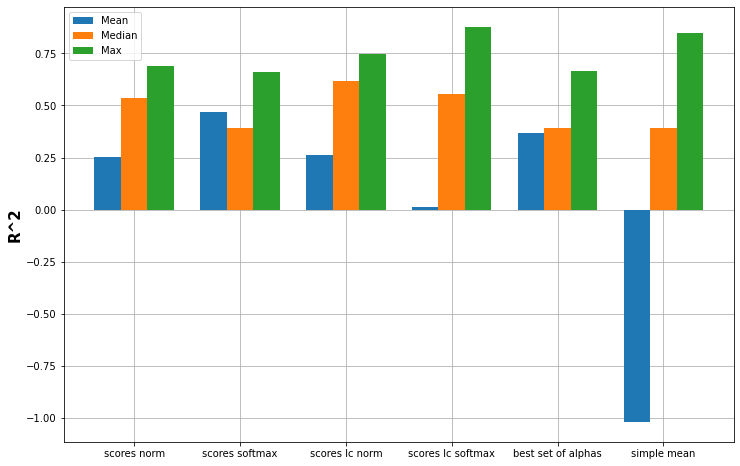

In [54]:
results = load('results_qtr_rs0.joblib')
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
plt.grid()
plt.gca().set_axisbelow(True)
 
# set height of bar
MEAN = [val.mean() for val in results.values()]
MEDIAN = [np.median(val) for val in results.values()]
MAX = [val.max() for val in results.values()]
 
# Set position of bar on X axis
br1 = np.arange(len(results))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, MEAN, width = barWidth, label ='Mean')
plt.bar(br2, MEDIAN, width = barWidth, label ='Median')
plt.bar(br3, MAX, width = barWidth, label ='Max')
 
# Adding Xticks
plt.ylabel('R^2', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(results.keys()))], list(results.keys()))
 
plt.legend()
plt.show()